In [1]:
import os, json, argparse
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from data_augmentation import *

from utils import *

from torch.utils.data import Subset, DataLoader, ConcatDataset
from torchvision import transforms
import torch
from torch import nn

import torchvision

from skimage.segmentation import felzenszwalb, slic, quickshift, watershed, mark_boundaries

import cv2
import kornia
from tqdm import tqdm
import numpy as np
import csv

Below we initialize our base filepath. First point to the base directory where you have the cholec80 dataset and want to keep all the processed video files/pngs. Depending on the processing you do this directory will hold 100s of GB of files minimum and possible over 4TB if you opt for the most cache intensive path. A solid state drive is recommended.

I also recommend setting up your dataset in this folder at this point. You will want to download the Cholec80 dataset and unzip it into a subfolder here (I made a subfolder here called 'datasets'). Then you will want to download the Smoke_Cholec80_v1.0.zip

Link for cholec source: http://camma.u-strasbg.fr/datasets

Link for cholec smoke dataset: https://zenodo.org/record/4515433#.ZES_ys7MIuU

NOTE: For cholec source you will need a valid research affiliation to get access to the dataset. Please only attempt access for valid research and projects.

In [2]:
pre_path = "C:/Users/Karol/Documents/DL4H" # Base directory, MUST HAVE LOTS OF SPACE 1TB minimum recommended

Here we run a quick test to make sure ffmpeg is installed and fuctioning. If you get an error here there is probably an issue with the environment.

In [3]:
import pims
path_raw_cholec = pre_path + "/datasets/cholec80/videos/video01.mp4"
if os.path.exists(path_raw_cholec):
    test = pims.Video(pre_path + "/datasets/cholec80/videos/video01.mp4")
else:
    print("No such file. Have you set up your data yet? This is also expected if you have run the data format conversion box below \"Playing With Choled Dataset\"")
    print("You will not get an error continuing if the latter is true.")

No such file. Have you set up your data yet? This is also expected if you have run the data format conversion box below "Playing With Choled Dataset"
You will not get an error continuing if the latter is true.


Below we generate all the artificial images of smoke. You can run generate_smoke.py in the libs folder alternatively. Make sure to setup your smoke_output_dir to point to where you want to keep smoke. This notebook is setup to output the files in a way that will work later in the notebook.

In [4]:
import sys
import time
import signal
from subprocess import Popen
from subprocess import PIPE

#MODIFY THIS SO THAT IT POINTS TO A DIRECTORY YOU WISH TO STORE THE FAKE SMOKE PNGs IN
smoke_subfolder = "/datasets/cholec80/synthetic_smoke/version2/"
smoke_output_dir = pre_path + smoke_subfolder

print(smoke_output_dir)
if not os.path.exists(smoke_output_dir):
	print("DIRECTORY DID NOT EXIST. CREATING...")
	time.sleep(5.0)
	os.makedirs(smoke_output_dir)

number_of_samples = 4000
num_workers = 8 #Set this to the number of physical CPU cores you have or slightly above if CPU usage is not reaching 100%

if len(os.listdir(smoke_output_dir)) >= number_of_samples:
	print("It appears that the smoke files have already been generated. Skipping.")
	print("If you would like to generate the files again please delete the directory or files in it.")

else:
	command = sys.executable + ' ' +  os.path.abspath('libs/pyclouds/generate_smoke.py')
	command += ' --end ' + str(number_of_samples) + ' --nworkers ' + str(num_workers)
	command += ' --bdir ' + smoke_output_dir
	runner = None
	try:
		runner = Popen(command, shell=True, stdout=PIPE, universal_newlines=True)
		while runner.poll() is None:
			for out in iter(runner.stdout.readline, ""):
				print(out)
	except KeyboardInterrupt:
		print("Exiting, ctrl+c")
		runner.send_signal(signal.CTRL_C_EVENT)
		runner.terminate()
		time.wait(10.0) #THIS MAY HAVE TO BE INCREASED FOR CLEAN EXIT ON VERY SLOW SYSTEMS
		sys.exit()

C:/Users/Karol/Documents/DL4H/datasets/cholec80/synthetic_smoke/version2/
It appears that the smoke files have already been generated. Skipping.
If you would like to generate the files again please delete the directory or files in it.


# Playing with Cholec Dataset

Code block below re-organizes cholec80 dataset into my prefered file format and integrates the Smoke_Cholec80_v1.0 dataset.

In [5]:
# WARNING RUN TO RE-ORGANIZE CHOLEC80 DATASET INTO MY PREFRED FILE FORMAT
# Assume we have a "fresh" cholec80 dataset and we want to make it into my file structure:
#  - top_level folder - video_folder - vid.mp4
#                                      smoke_label
#                                      frame_label
#                                      phase_annotations
#                                      tool_annotation

import shutil

# YOU WILL NEED TO MODIFY THE BELOW PATHS IF WHERE YOU KEEP EACH PART OF THE DATA DIFFERS FROM HOW I SET THINGS UP

vid_path_parent = pre_path + '/datasets/cholec80/videos/'
tool_txt_path_parent = pre_path + '/datasets/cholec80/tool_annotations/'
smoke_csv_path_parent = pre_path + '/datasets/cholec80/Smoke_Cholec80_v1.0/cholec80_mappings/'
phase_txt_path_parent = pre_path + '/datasets/cholec80/phase_annotations/'

# MODIFY THE BELOW LINE TO SET THE DIRECTORY FOR THE FORMATTED AND COMBINED DATASET. DO NOT ADVISE MAKING THIS THE SAME AS vid_parent_path

out_path_parent = pre_path + '/datasets/cholec80/input_formatted'

vid_file_list = [ f for f in os.listdir(vid_path_parent) if f.endswith('.mp4')]

for vid_file_name in vid_file_list:
    vid_name = os.path.splitext(vid_file_name)[0]
    
    out_folder = os.path.join(out_path_parent, vid_name)
    tool_txt_path = os.path.join(tool_txt_path_parent, vid_file_name + '.csv')
    
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
    
    # Move video file
    shutil.move(os.path.join(vid_path_parent, vid_file_name), 
                os.path.join(out_folder, vid_file_name))
    # Move companioning csv video file
    shutil.move(os.path.join(vid_path_parent, vid_name + '-timestamp.txt'), 
                os.path.join(out_folder, 'timestamp.txt'))
    # Move tool annotation file
    shutil.move(os.path.join(tool_txt_path_parent, vid_name + '-tool.txt'), 
                os.path.join(out_folder, 'tool_annotation.csv'))
        # Move phase annotation file
    shutil.move(os.path.join(phase_txt_path_parent, vid_name + '-phase.txt'), 
                os.path.join(out_folder, 'phase_annotation.csv'))
    # Move smoke annotation file
    shutil.move(os.path.join(smoke_csv_path_parent, vid_file_name + '.csv'), 
                os.path.join(out_folder, 'smoke_annotation.csv'))

Here we declare a couple arguments which will be used in subsequent data analysis and data loaders. Please set these appropriately to your dataset.

You will want to remove some of the video folders, or keep en_vpcache disabled below. Enabling it will output every video as PNG files into the cache_subfolder. This can take multiple TB for the whole dataset. The first 10 videos will take up a little over 390GB.

For the project videos 1-20 were used for training and validation taking up a little under 660GB of cache data not including the input data.

In [6]:
#CHANGETHIS
cache_subfolder = '/datasets/cholec80/cache'
syn_smoke_subfolder = '/datasets/cholec80/synthetic_smoke/'
en_vpcache = True # Changing this to true with the whole dataset present will cause the next step to consume up to 4TB of data in the next step.
#DO NOT CHANGE BELOW HERE

args = {
        'size': 512,
        'dataset': out_path_parent,
        'cache': pre_path + cache_subfolder,
        'smoke': pre_path + syn_smoke_subfolder,
        'subsample': 5,
        'multiframe': []
}

if en_vpcache == False:
    args['cache'] = None


#Taking these metrics at half resolution so it does not take forever. Still takes 80 hours or so for the whole dataset.
vid_transform = transforms.Compose([
                                    transforms.Resize((int(args['size']/2), int(args['size']/2))),
                                    transforms.ConvertImageDtype(torch.float32),
                                  ])

Now we will look at the image quality metrics which are important to selecting training frames from the videos we have available.

We use the getVidData loader to load in our dataset in quality metrics mode. Here the loader is assesing every single frame for laplacian variance, color, and brightness. These appear to be good metrics for selecting frames that will provide the model lots of vibrant visual data to train on. Using this kind of data which is easier for a human to interpret will also produce denoised images which are closer to what would be helpful to a surgeon to differentiate between different features in the image during surgery.

The metrics are calculated as shown:

Laplacian Variance:

color:

brightness:



NOTE: THIS PART CAN TAKE 80+ HOURS TO COMPLETE ON A RYZEN 5800x3D. PLEASE BE AWARE OF THE RUNTIME BEFORE STARTING THIS PROCESS. PLEASE HAVE ENOUGH DISK SPACE TOO. READ INFORMATION ABOVE!!! 1TB+

Once the data is processed once, running this cell will only take seconds. Please ignore the message about recomputing the CSV if it shows up. This appears to be a bug with one of the libraries used.

In [7]:
img_quality_data = getVidData(vid_dataset_path = args['dataset'],
                              loader_type="qual",
                              vid_dataset_cache_path = args['cache'],
                              transform = vid_transform,
                              scope_cropping = True,
                              clear_csv = False,
                              clear_cache_directory=False,
                              )

CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 43325 but video length is 43326. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video01\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 70975 but video length is 70976. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video02\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 145700 but video length is 145701. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video03\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 38050 but video length is 38051. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video04\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 58600 but video length is 58601. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video05\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 53825 but video length is 53826. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video06\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 113925 but video length is 113926. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video07\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 37975 but video length is 37976. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video08\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 67550 but video length is 67551. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video09\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 43725 but video length is 43726. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video10\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 80500 but video length is 80501. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video11\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 27250 but video length is 27251. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video12\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 24525 but video length is 24526. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video13\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 42700 but video length is 42701. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video14\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 51450 but video length is 51451. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video15\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 73925 but video length is 73926. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video16\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 32600 but video length is 32601. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video17\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 48550 but video length is 48551. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video18\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 60600 but video length is 60601. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video19\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 36225 but video length is 36226. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video20\quality_metrics.csv.


NUM ROWS IN CSV WRONG


Now we will plot these metrics to visualize our data at a high level.

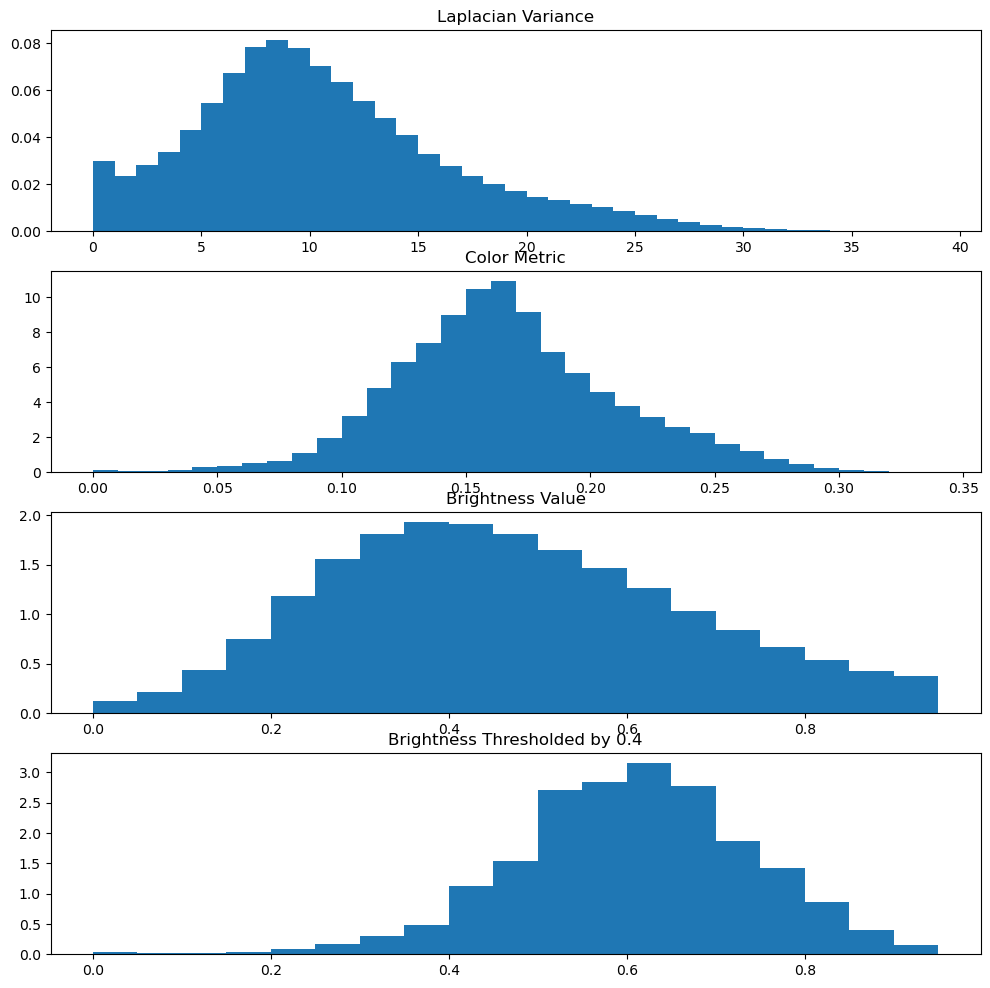

In [8]:
laplacian_variance_data = torch.cat([d.lap for d in img_quality_data])
color_data = torch.cat([d.col for d in img_quality_data])
brightness_data = torch.cat([ torch.cat(d.bright) for d in img_quality_data])

b_th = 0.4
brightness_thresh_data = [ torch.tensor([ torch.sum(img_d > b_th)/len(img_d) 
                                                for img_d in d.bright])  
                                                    for d in img_quality_data ]
brightness_thresh_data = torch.cat(brightness_thresh_data)

fig, axs = plt.subplots(4, 1, figsize=(12, 12))
axs[0].hist(laplacian_variance_data.cpu().numpy(), bins = np.arange(0, 40, 1), density = True)
axs[0].set_title('Laplacian Variance')
axs[1].hist(color_data.cpu().numpy(), bins = np.arange(0, 0.35, 0.01), density = True)
axs[1].set_title('Color Metric')
axs[2].hist(brightness_data.cpu().numpy(), bins = np.arange(0, 1, 0.05), density = True)
axs[2].set_title('Brightness Value')
axs[3].hist(brightness_thresh_data.cpu().numpy(), bins = np.arange(0, 1, 0.05), density = True)
axs[3].set_title('Brightness Thresholded by {}'.format(b_th))

plt.show()

Declaring a utility function to help us turn out loaded tensor into an image.

In [9]:
def imshow_tensor(axs_ref, tensor, denormalize = False):
    '''
        axs_ref: reference to matplotlib axs for plotting.
        tensor: C, H, W image tensor
    '''
    if denormalize:
        tensor = (tensor + 1.0)/2.0

    axs_ref.imshow(kornia.utils.tensor_to_image(transforms.ConvertImageDtype(torch.uint8)(tensor.cpu())))

Here we take a look at how many images are above our cutoff metrics:
Laplacian Variation of 15
color metric of 0.15
and brightness metric of 0.8

Then we calculate the rough expected dataset size for synthetic smoked images + base truth images. Then we sample a couple of these selected images in a grid to see if our cutoffs are satisfactory. This step is entirely subjective as we are selecting for 'good' human interpretable features in images.

Length of full dataset 1151995
Length of new dataset 14162
Assuming 0.0004gb per img, 10 synth images per raw, then total size is expected: 169.94400000000002gb


c:\Users\Karol\.conda\envs\DL4H_CS598\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


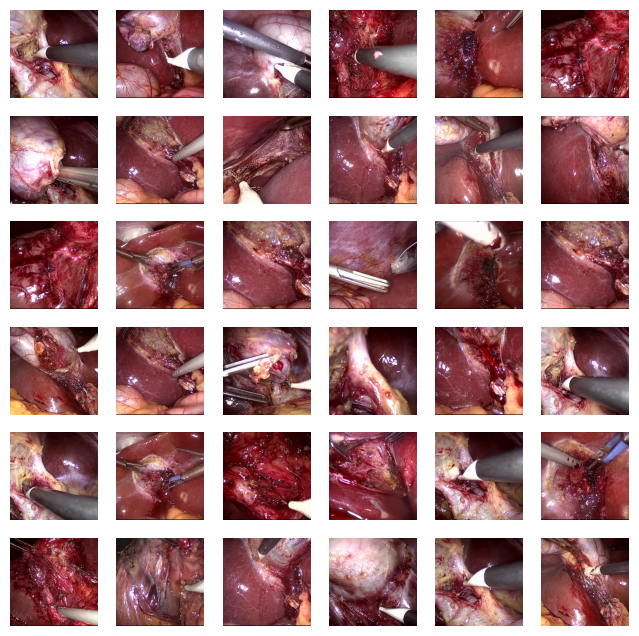

In [10]:
# Randomly sample from top of distributions??
l_th = 15
c_th = 0.15
b_th_th = 0.8
num_rand = 6**2

full_dataset = ConcatDataset(img_quality_data)
mask = (laplacian_variance_data > l_th)*(color_data > c_th)*(brightness_thresh_data > b_th_th)

dataset = Subset(full_dataset, torch.nonzero(mask))

print("Length of full dataset {}".format(len(full_dataset)))
print("Length of new dataset {}".format(len(dataset)))

img_size = 0.0004 #gb
num_synth_images_per_raw_img = 10
dataset_size = len(dataset)*img_size*num_synth_images_per_raw_img*3
print("Assuming {}gb per img, {} synth images per raw, then total size is expected: {}gb".format(img_size, num_synth_images_per_raw_img, dataset_size))

rand_img_idx = torch.randint(len(dataset), (num_rand,))
fig, axs = plt.subplots(int(np.sqrt(num_rand)), int(np.sqrt(num_rand)), figsize=(8, 8))
for img_idx, ax in zip(rand_img_idx, axs.flat):
    imshow_tensor(ax, dataset[img_idx][0])
    ax.axis('off')

Now we will visualize some of the pictures that we rejected for comparison. See how they generally have less useful information in them? Typically these will be of less use to a human.

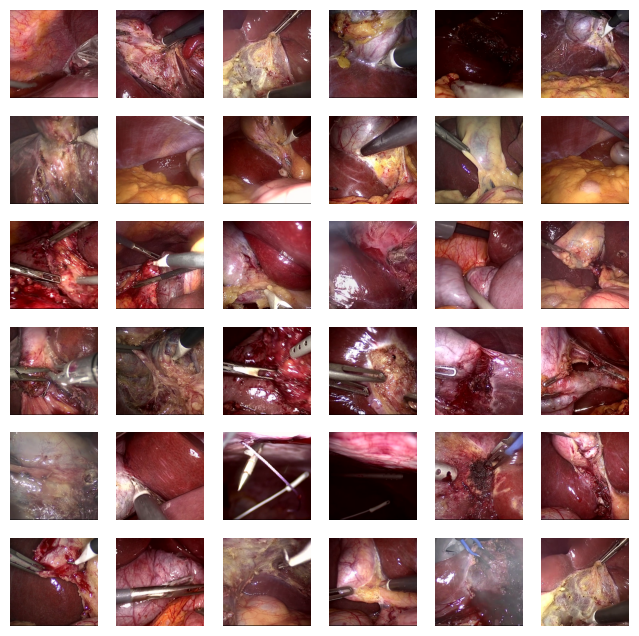

In [11]:
# Visualize random rejected data:
dataset = Subset(full_dataset, torch.nonzero(torch.logical_not(mask)))

rand_img_idx = torch.randint(len(dataset), (num_rand,))
fig, axs = plt.subplots(int(np.sqrt(num_rand)), int(np.sqrt(num_rand)), figsize=(8, 8))
for img_idx, ax in zip(rand_img_idx, axs.flat):
    imshow_tensor(ax, dataset[img_idx][0])
    ax.axis('off')

Here we declare a bunch of transforms which we will use to compose our sythetically smoked images. Many transforms here are added in order to increase the general performance of the model. Specifics of how this was accomplished are not in the original paper, so we use our own augmentation.

In [12]:
# Prepare all the transforms and synthetic smoke loaders

# Transforms applied only to the synthetic smoke PNGs we generated at the start
synth_smoke_transforms = transforms.Compose([
                                            transforms.ConvertImageDtype(torch.float32),
                                            torchvision.transforms.CenterCrop((512, 512)),
                                             HazeImage_RGBA(t=(0.8, 1.0), std_t=(0.0, 0.0), speckle_t=(0.0, 0.0), # Haze only works on rgba and must be applied to the alpha composited layer.
                                                            a=(0.6, 0.8), std_a=(0.0, 0.0), speckle_a=(0.0, 0.0),
                                                            keepdim=True, p = 0.5),
                                             SpeckleImage(std = (0.00, 0.01), speckle = (0.0, 0.025),
                                                         keepdim=True, p = 0.5),
                                              RandomHueRGBA(hue=(-0.15, 0.15)),
                                              Darken(alpha = (0.95, 1.05), beta = (0.95, 1.05), 
                                                     gamma = (0.9, 1.1), keepdim=True, p = 0.5),
                                            ])

# Transforms which are applied to the 'high quality' images we just selected in the last step.
bg_img_transform = transforms.Compose([
                                       transforms.GaussianBlur(9, sigma=(0.01, 2.0)),
                                       kornia.augmentation.RandomBoxBlur(p=0.5, keepdim=True),
                                       kornia.augmentation.RandomMotionBlur(p=0.5, 
                                                                            kernel_size = (3, 13), 
                                                                            angle = (0, 360), 
                                                                            direction = (-1.0, 1.0),
                                                                            border_type = 'replicate',
                                                                            keepdim=True),
                                       Darken(alpha = (0.9, 1.0), beta = (0.9, 1.0), 
                                              gamma = (1.0, 2.0), keepdim=True, p = 0.5),
                                      ])

# Unimportant for our use. This transform would be useful if we were using temporally consistent
prev_frame_transform = None # We are only using single frame input so anything here is wasted processing.

target_frame_transform = transforms.Compose([
                                            kornia.augmentation.RandomSaturation(saturation=(1.2, 1.2), 
                                                                                 p=1.0, keepdim=True),
                                            ])

output_transform_synth = transforms.Compose([
                                            transforms.ConvertImageDtype(torch.float32),
                                            transforms.RandomRotation((-5.0, 5.0)),
                                            torchvision.transforms.RandomResizedCrop((args['size'], args['size'])),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomVerticalFlip(),
                                            transforms.Normalize(mean = 0.5, std = 0.5),
                                            ])

output_transform_synth_preview = transforms.Compose([
                                            transforms.ConvertImageDtype(torch.float32),
                                            transforms.RandomRotation((-5.0, 5.0)),
                                            torchvision.transforms.RandomResizedCrop((args['size'], args['size'])),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomVerticalFlip(),
                                            # transforms.Normalize(mean = 0.5, std = 0.5), # This should only be used for the model since output from the generator is tanh (-1,1) and images expect (0,1) for viewing.
                                            ])

output_transform_real = transforms.Compose([
                                            transforms.ConvertImageDtype(torch.float32),
                                            torchvision.transforms.Resize((args['size'], args['size'])),
                                            transforms.Normalize(mean = 0.5, std = 0.5),
                                            ])

vid_transform = transforms.Compose([
                                    torchvision.transforms.Resize((args['size'], args['size'])),
                                    transforms.ConvertImageDtype(torch.float32),
                                   ])


synth_smoke_data = ConcatDataset([SmokeDirectoryLoader(os.path.join(args['smoke'], directory), 
                                                                    synth_smoke_transforms) 
                                    for directory in os.listdir(args['smoke'])  
                                    if os.path.isdir(os.path.join(args['smoke'], directory))])

In [13]:
# Do synthetic data augmentation on an image right before smoke appears and compare against after smoke appears
# Compare visually (by looking) and some pixel distributions/metrics

vid_data = getVidData(vid_dataset_path = args['dataset'],
                      loader_type="cholec_smoke",
                      vid_dataset_cache_path = None,
                      transform = vid_transform,
                      scope_cropping = True,
                      clear_cache_directory=False,
                      )

Verify number of videos is correct as you expect.

In [14]:
len(vid_data)

20

Now we are going to output some smoked frames to see how our transforms impact our images. Check the x and y axis to make sure the image is the resolution you expected! I used 512x512 unlike the 256x256 the source paper used.

c:\Users\Karol\.conda\envs\DL4H_CS598\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


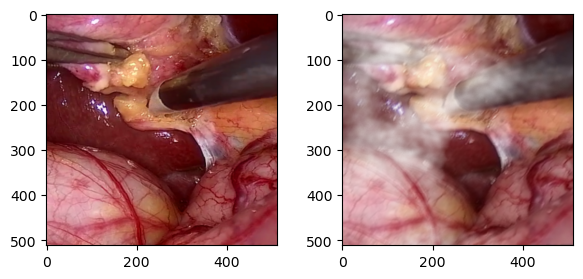

In [15]:
# Check a sequence of synthetically generated images (want to look that the mult-frame is consistent)
#   This doesn't use the image quality filter, just looks at any image
vid_idx = 8     # THIS NUMBER MUST BE LESS THAN THE NUMBER OF VIDEOS YOU ARE USING ON INPUT

def atmospheric_scattering_compose(vid_img:torch.tensor, smoke_img:torch.tensor) -> Union[torch.tensor, torch.tensor]:
    '''
        vid_img input need to be of shape 3xWxH with floating point RGB channels
        smoke_img input need to be of shape 4xWxH with floating point RGBA channels
        
        Note that despite this being the atmospheric scattering model, it is in fact equivalent to alpha composition when
        the background (atmospheric) light is assumed to be pure white. Note that I have modified this compose to only apply 0.85
        as I found this gave a better smoke effect. This is due to the fact that the smoke generation is probably not tuned finely enough

        Outputs are of form 3xWxH and WxH
    '''
    #tuning_alpha = 0.85 #PUT THIS DIRECTLY IN TO GAIN A LITTLE SPEED
    out_img = vid_img*(1 - 0.85*smoke_img[-1, :, :]) + smoke_img[:-1, :, :]*smoke_img[-1, :, :]*0.85
    out_img[out_img > 1] = 1

    out_mask = smoke_img[-1, :, :]
    return out_img, out_mask

syn_data = SynthSmokeLoader(vid_data[vid_idx], synth_smoke_data,
                            bg_img_transform = bg_img_transform,
                            idx_of_prev_frame = args['multiframe'],
                            output_transform = output_transform_synth_preview,
                            prev_frame_transform = prev_frame_transform,
                            cache_directory = None,
                            target_transform = target_frame_transform,
                            compose_function=atmospheric_scattering_compose,)

num_imgs = len(args['multiframe']) + 1

# Plot input images
fig, axs = plt.subplots(1, num_imgs + 1, figsize=(7, 3))
data_tuple = syn_data[10000]

img_channels = int(data_tuple[0].shape[0]/num_imgs)

imshow_tensor(axs[0], data_tuple[2])
for t in range(num_imgs):
    imshow_tensor(axs[t + 1], data_tuple[0][t*img_channels:(t+1)*img_channels])

Now we actually generate the synthetic dataset using the higher level loader. This one utilizes the getVidData loader, SynthSmokeLoader, and SmokeDirectoryLoader internally to process the data appropriately in 'cholec_smoke' mode. Running this with 4000 smoke imgaes on the first 20 videos took 698 minutes or 11 hours and 38 minutes on a 5800x3D

In [17]:

# Add name to call the top-level folders
synth_smoke_dataset_list, real_smoke_dataset_list = getDatasets(vid_dataset_path = args['dataset'],
                                                                loader_type = 'cholec_smoke',
                                                                vid_dataset_cache_path = args['cache'],
                                                                cache_path_synth_smoke = os.path.join(args['cache'], "new_synth_smoke"),
                                                                cache_path_real_smoke  = os.path.join(args['cache'], "real_smoke"),
                                                                vid_transform = vid_transform,
                                                                vid_dataset_apply_scope_cropping = True,
                                                                smoke_dataset_path = args['smoke'],
                                                                synth_smoke_transforms = synth_smoke_transforms,
                                                                multi_frame = args['multiframe'],
                                                                bg_img_transform = bg_img_transform,
                                                                output_transform_synth = output_transform_synth,
                                                                output_transform_real = output_transform_real,
                                                                prev_frame_transform = prev_frame_transform,
                                                                l_th = 15,
                                                                c_th = 0.15,
                                                                b_th_th = 0.8,
                                                                target_transform = target_frame_transform,
                                                                clear_cache_directory=False,
                                                                compose_function=atmospheric_scattering_compose)

CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 43325 but video length is 43326. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video01\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 70975 but video length is 70976. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video02\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 145700 but video length is 145701. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video03\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 38050 but video length is 38051. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video04\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 58600 but video length is 58601. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video05\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 53825 but video length is 53826. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video06\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 113925 but video length is 113926. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video07\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 37975 but video length is 37976. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video08\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 67550 but video length is 67551. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video09\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 43725 but video length is 43726. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video10\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 80500 but video length is 80501. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video11\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 27250 but video length is 27251. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video12\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 24525 but video length is 24526. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video13\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 42700 but video length is 42701. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video14\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 51450 but video length is 51451. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video15\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 73925 but video length is 73926. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video16\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 32600 but video length is 32601. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video17\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 48550 but video length is 48551. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video18\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 60600 but video length is 60601. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video19\quality_metrics.csv.


NUM ROWS IN CSV WRONG
CSV IS STILL GOOD SO GOOD
CSV is good?


Number of rows in csv file is 36225 but video length is 36226. Recommend deleting csv file so it is recomputed: C:/Users/Karol/Documents/DL4H/datasets/cholec80/input_formatted\video20\quality_metrics.csv.


NUM ROWS IN CSV WRONG
43326
43325
70976
70975
145701
145700
38051
38050
58601
58600
53826
53825
113926
113925
37976
37975
67551
67550
43726
43725
80501
80500
27251
27250
24526
24525
42701
42700
51451
51450
73926
73925
32601
32600
48551
48550
60601
60600
36226
36225


c:\Users\Karol\.conda\envs\DL4H_CS598\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


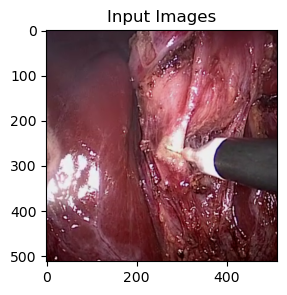

In [21]:
# Check idx of real smoked image(s)
real_smoke_dataset = ConcatDataset(real_smoke_dataset_list)
idx = -700

num_imgs = len(args['multiframe']) + 1
img_channels = int(real_smoke_dataset[idx][0].shape[0]/num_imgs)

# Plot input images
fig, axs = plt.subplots(1, num_imgs, figsize=(10, 3))
plt.title("Input Images")

if num_imgs > 1:
    for t in range(num_imgs):
        imshow_tensor(axs[t], real_smoke_dataset[idx][0][t*img_channels:(t+1)*img_channels]  , denormalize = True)
else:
    imshow_tensor(axs, real_smoke_dataset[idx][0][:img_channels]  , denormalize = True)

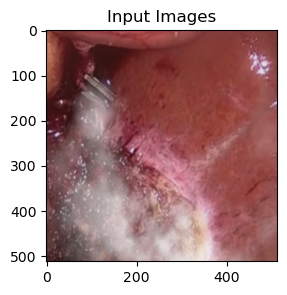

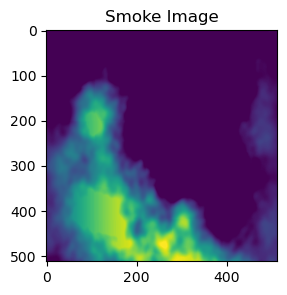

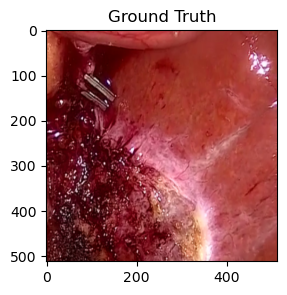

In [26]:
# Check idx of synthetically smoked image(s)
synth_smoke_dataset = ConcatDataset(synth_smoke_dataset_list)

dataset_tuple = synth_smoke_dataset[idx]

idx = int(-100)

num_imgs = len(args['multiframe']) + 1
img_channels = int(dataset_tuple[0].shape[0]/num_imgs)

# Plot input images
fig, axs = plt.subplots(1, num_imgs, figsize=(10, 3))
plt.title("Input Images")
if num_imgs > 1:
    for t in range(num_imgs):
        imshow_tensor(axs[t], dataset_tuple[0][t*img_channels:(t+1)*img_channels], denormalize=True)
else:
    imshow_tensor(axs, dataset_tuple[0][0:img_channels], denormalize=True)

    
# Plot ground truth
smoke_channels = int(dataset_tuple[1].shape[0]/num_imgs)
fig, axs = plt.subplots(1, num_imgs, figsize=(10, 3))
plt.title("Smoke Image")
if num_imgs > 1:
    for t in range(num_imgs):
        imshow_tensor(axs[t], dataset_tuple[1][t*smoke_channels:(t+1)*smoke_channels], denormalize=True)
else:
    imshow_tensor(axs, dataset_tuple[1][0:smoke_channels], denormalize=True)
    

# Plot ground truth
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.title("Ground Truth")
imshow_tensor(axs, dataset_tuple[2], denormalize=True)